In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns # a visualization package
from sklearn import linear_model
import statsmodels.api as sm
import copy
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

import warnings

<img src="raw/dfTraffic.png" width="600" height="500">

In [2]:
df = pd.read_csv('raw/Traffic.csv')
df.tail()

,flow,occupancy,speed,speed_down,flow_ratio
1811,17,2.4,66.2,65.511776,0.607143
1812,20,2.6,66.3,67.620371,0.666667
1813,19,2.6,66.2,65.665838,0.655172
1814,15,2.4,66.1,65.638604,0.576923
1815,18,2.7,65.8,64.370269,0.620690


<hr style="border-top: 0.5px solid #b;">
<b style="font-size: 22px;">Task1</b> <h style="font-size: 18px;"> : Visualise the relationship between every two variables. </h>
<hr style="border-top: 0.5px solid #b;">

In [3]:
warnings.filterwarnings("ignore", category=FutureWarning)

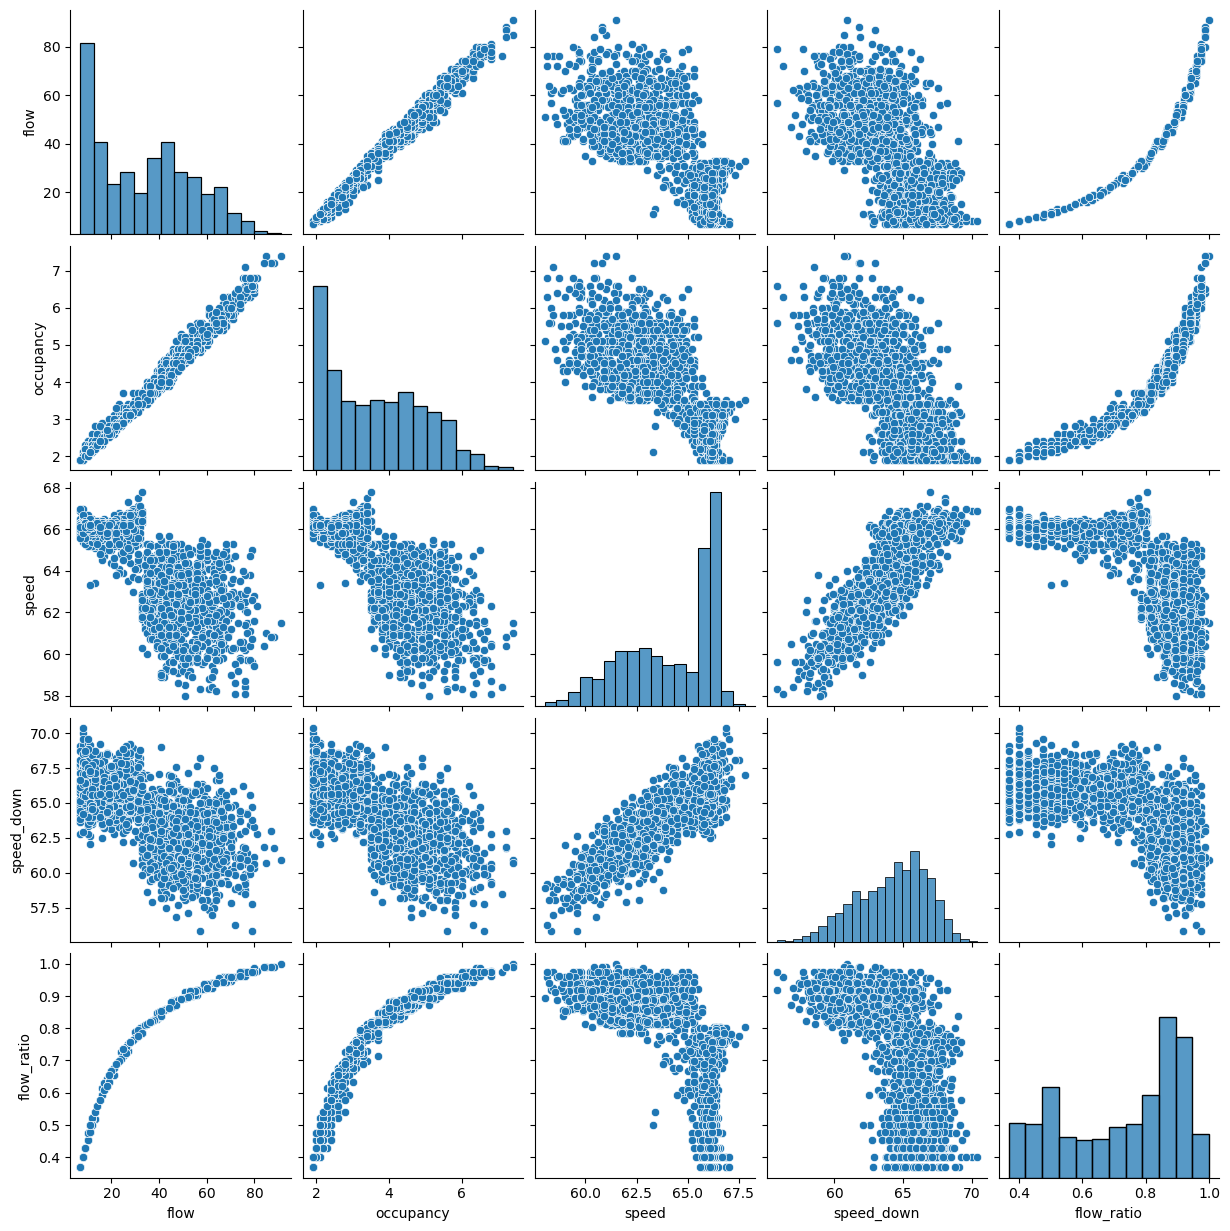

In [4]:
sns.pairplot(df);

<hr style="border-top: 0.5px solid #b;">
<b style="font-size: 22px;">Task2</b> <h style="font-size: 18px;">  : Fit a multiple linear regression model to the original dataset. Does the model suffer a multicollinearity problem? If yes, which variables cause this issue? </h>
<hr style="border-top: 0.5px solid #b;">

In [5]:
cols_x = ['flow', 'occupancy', 'flow_ratio', 'speed_down']
X = df[cols_x] 
y = df['speed']

X_ols = sm.add_constant(X)
model = sm.OLS(y, X_ols)
result = model.fit()

print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                  speed   R-squared:                       0.841
Model:                            OLS   Adj. R-squared:                  0.841
Method:                 Least Squares   F-statistic:                     2398.
Date:                Wed, 13 Mar 2024   Prob (F-statistic):               0.00
Time:                        20:16:32   Log-Likelihood:                -2321.4
No. Observations:                1816   AIC:                             4653.
Df Residuals:                    1811   BIC:                             4680.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         38.9687      0.904     43.095      0.0

##### Check for multicollinearity

                flow  occupancy  flow_ratio  speed_down
flow        1.000000   0.993891    0.942135   -0.673001
occupancy   0.993891   1.000000    0.932341   -0.696856
flow_ratio  0.942135   0.932341    1.000000   -0.650333
speed_down -0.673001  -0.696856   -0.650333    1.000000


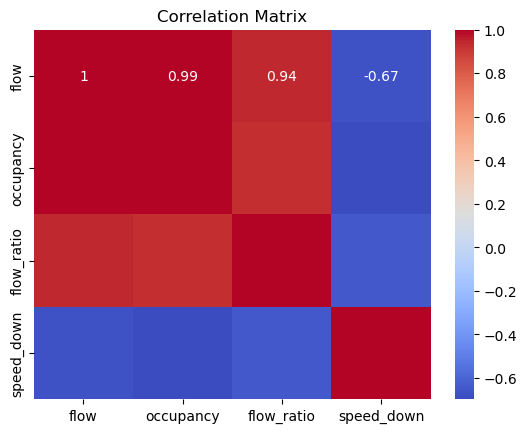

In [6]:
corr_matrix = X.corr()                                                # corralation matrix for every pair of the variables
print(corr_matrix)                

sns.heatmap(corr_matrix,                                              # generate a heatmap 
            annot=True, cmap='coolwarm')                              # set properties          
plt.title('Correlation Matrix')
plt.show()

In [7]:
threshold = 0.9                                                       # Set a threshold for high correlation
highly_correlated_vars = []                                           # initiate the list object
n = len(X.columns)                                                    # define the number of loop (4 x 4)

for i in range(n):                                                    # loop over row
    for j in range(i+1, n):                                           # loop over columns start from i+1 to avoid redundant classification
        correlation = corr_matrix.iloc[i, j]
        if abs(correlation) > threshold:
            var1 = X.columns[i]
            var2 = X.columns[j]
            highly_correlated_vars.append((var1, var2))

for var1, var2 in highly_correlated_vars:
    print(f"{var1} and {var2} are highly correlated.")

flow and occupancy are highly correlated.
flow and flow_ratio are highly correlated.
occupancy and flow_ratio are highly correlated.


<hr style="border-top: 0.5px solid #b;">
<b style="font-size: 22px;">Task3</b> <h style="font-size: 18px;">  : Select suitable independent variables for the regression model. Note, you may need to do some transformations on the original variables. Explain why you do these transformations, and why you choose these variables? </h>
<hr style="border-top: 0.5px solid #b;">

As discussed in Task2, flow, flow ratio, and occupanry are in a significant multicollinearity relationship.<br>
To avoid any negative impacts towards the model from feeding individual variables with multicollinearity while maintaining the value of each of these variables, I propose to combine these three variables into one meaningful variable called 'slow_line_utilization_index'.<br>
<br>This is done through two steps <br>(1) introducing a new variable 'flow_density' <br>(2) introducing a new variable 'slow_line_utilization_index'


<h style="font-size: 19px;"> (1) Introduce 'flow_density' </h> <br><br>
Flow density represents the number of vehicles per unit length, indicating the level of trafic congestion or the road utilization.<br>
In this context, it is # vehicles during the 5 minutes interval (each sample) where higher flow_density indicates higher trafffic congestion<br>
<br>
The formula of deriving flow density is as follows: <br>
flow_density = flow / occupancy

In [8]:
df_updated = copy.deepcopy(df)
df_updated['flow_density'] = df['flow'] / df['occupancy']
df_updated.head(2)

,flow,occupancy,speed,speed_down,flow_ratio,flow_density
0,21,2.7,66.1,65.909191,0.677419,7.777778
1,15,2.4,66.2,66.598417,0.576923,6.250000


<h style="font-size: 19px;"> (2) Introduce 'slow_line_utilization_index' </h> <br><br>
Now, a new variable 'slow_line_utilization_index' is introduced using 'flow_ratio' and 'flow_density'.<br>
Before doing so, the characteristics of the variable 'flow_ratio' must be understood better<br>

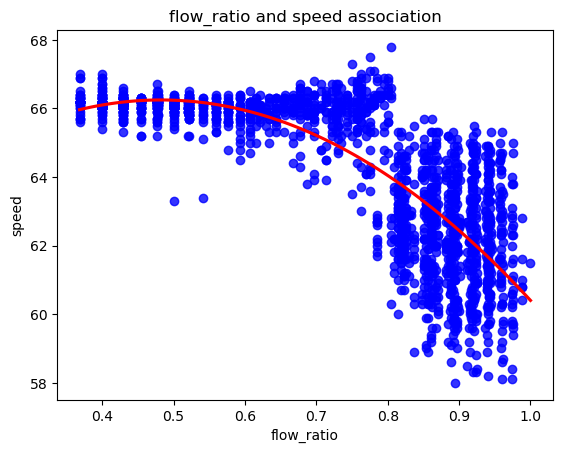

In [9]:
sns.regplot(x = df_updated['flow_ratio'],
            y = df_updated['speed'], 
            order = 2, 
            scatter = True, ci = None,
            scatter_kws={'color': 'blue'}, line_kws={'color': 'red'})

plt.xlabel('flow_ratio')
plt.ylabel('speed')
plt.title('flow_ratio and speed association')

plt.show()

The scatter plot and fitted line for 'flow_ratio' versus 'speed' show a distinct trend: a higher 'flow_ratio' typically results in reduced speed.
<br>
The analysis suggests that 'flow_ratio' is associated with a slower line, whereas the adjacent line is faster.
<br><br>
Shifting focus to 'flow_density,' we now examine the combined flow density of both lanes, then hone in on the 'slow_line_utilization_index' for the specific slower lane. This index reflects the flow in the slower lane relative to the faster lane, taking traffic intensity ('flow_density') into account.
<br><br>
The 'slow_line_utilization_index' is calculated as follows:
slow_line_utilization_index = flow_ratio * flow_density

In [10]:
df_updated['slow_line_utilization_index'] = round(df_updated['flow_ratio'] * df_updated['flow_density'],2)
df_updated = df_updated.drop(['flow', 'occupancy', 'flow_ratio', 'flow_density'], axis = 1)
df_updated

,speed,speed_down,slow_line_utilization_index
0,66.1,65.909191,5.27
1,66.2,66.598417,3.61
2,66.1,64.354384,3.41
3,66.2,64.640938,4.13
4,66.2,66.139489,3.76
...,...,...,...
1811,66.2,65.511776,4.30
1812,66.3,67.620371,5.13
1813,66.2,65.665838,4.79
1814,66.1,65.638604,3.61


<h style="font-size: 19px;"> Check for multicollneariy again </h>

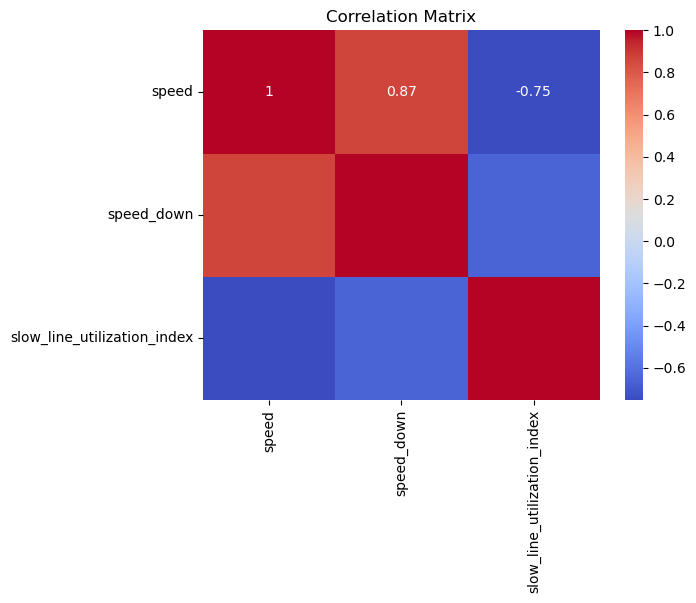

In [11]:
df_updated_corr = df_updated.corr()
sns.heatmap(df_updated_corr,                                        
            annot=True, cmap='coolwarm')                               
plt.title('Correlation Matrix')
plt.show()

Now, we have a meaningful new variable that is generated from 'flow', 'occupancy' and 'flow_ratio' and observe much less multicollneariy among independent variables. The linear model is fit using two independent variables 'slow_line_utilization_index' and 'speed_down'.

In [12]:
cols_x = ['slow_line_utilization_index', 'speed_down']
X = df_updated[cols_x] 
y = df_updated['speed']

X_ols = sm.add_constant(X)
model = sm.OLS(y, X_ols)
result = model.fit()

print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                  speed   R-squared:                       0.814
Model:                            OLS   Adj. R-squared:                  0.814
Method:                 Least Squares   F-statistic:                     3968.
Date:                Wed, 13 Mar 2024   Prob (F-statistic):               0.00
Time:                        20:16:33   Log-Likelihood:                -2464.8
No. Observations:                1816   AIC:                             4936.
Df Residuals:                    1813   BIC:                             4952.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

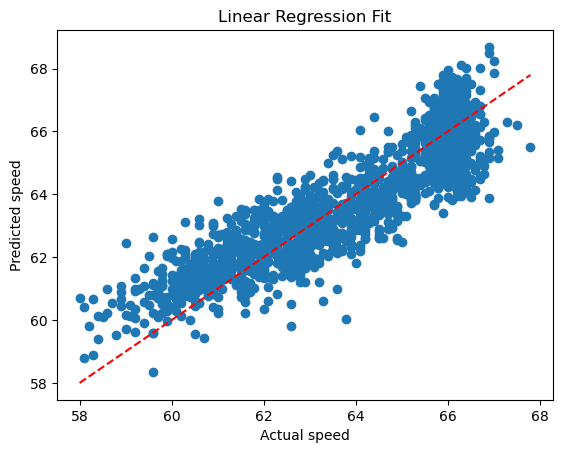

In [13]:
# Generate predicted values using the fitted model
y_pred = result.predict(X_ols)

# Plot the regression fit
plt.scatter(y, y_pred)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')  # Plot the diagonal line
plt.xlabel('Actual speed')
plt.ylabel('Predicted speed')
plt.title('Linear Regression Fit')
plt.show()

<hr style="border-top: 0.5px solid #b;">
<b style="font-size: 22px;">Task4</b> <h style="font-size: 18px;">  : Apply linear regression, ridge regression, and lasso regression to estimate the relationship between the average speed of the segment and the independent variables you selected. Compare the results of different models and verify the variable you selected. (tip: what is the function of the regularised term?) </h>
<hr style="border-top: 0.5px solid #b;">

To compare the performance of the three regession model, MSE between the prediction and the test values of y are being compared. <br>
During the process, the K-fold validation is being implemented to minimize the variablity of the result. <br>
Also, in each round of K-fold, the range of alpha(lambda) of rigde and lasso regression between 0.01 to 10 with step of 0.01 are being tested to find the best parameter using RidgeCV and LassoCV function among 5 cross validations.

In [14]:
n_splits = 5                                                          # split the dataset into 5 during the K-folding 

linear_reg_mse_list = []                                              # instantiate the list object for storing linear regression MSEs
ridge_reg_mse_list = []                                               # instantiate the list object for storing ridge regression MSEs
lasso_reg_mse_list = []                                               # instantiate the list object for storing lasso regression MSEs

kf = KFold(n_splits = n_splits, shuffle = True)                       # shuffle the dataset and split it into 5 batches
for train_index, test_index in kf.split(X):                           # in each iteration, index of the dataset is randomly assigned to train and test
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]         # define X_train and X_test by split index
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]         # define y_train and y_test by split index

    linear_reg = linear_model.LinearRegression()                      # Linear Regression
    linear_reg.fit(X_train, y_train)                                  # train model with train dataset
    linear_reg_predictions = linear_reg.predict(X_test)               # predict y using test X data
    linear_reg_mse = mean_squared_error(y_test,                       # derive MSE between y_pred and y_test
                                        linear_reg_predictions)
    linear_reg_mse_list.append(linear_reg_mse)                        # store MSE of each round

    ridge_reg = linear_model.RidgeCV(alphas = (0.01, 10, 0.01),       # Ridge Regression, searching the best alpha from 0.01 to 10 with 0.01 steps
                                     cv = 5)
    ridge_reg.fit(X_train, y_train)
    ridge_reg_predictions = ridge_reg.predict(X_test)
    ridge_reg_mse = mean_squared_error(y_test, ridge_reg_predictions)
    ridge_reg_mse_list.append(ridge_reg_mse)

    lasso_reg = linear_model.LassoCV(alphas = (0.01, 10, 0.01),       # Lasso Regression
                                     cv = 5)
    lasso_reg.fit(X_train, y_train)
    lasso_reg_predictions = lasso_reg.predict(X_test)
    lasso_reg_mse = mean_squared_error(y_test, lasso_reg_predictions)
    lasso_reg_mse_list.append(lasso_reg_mse)

linear_reg_mse_avg = np.mean(linear_reg_mse_list)                     # Calculate the average MSE across folds for each model
ridge_reg_mse_avg = np.mean(ridge_reg_mse_list)
lasso_reg_mse_avg = np.mean(lasso_reg_mse_list)


print("Average of the Linear Regression MSEs:", linear_reg_mse_avg)   # Print the MSEs for each model
print("Average of the Ridge Regression MSEs:", ridge_reg_mse_avg)
print("Average of the Lasso Regression MSEs:", lasso_reg_mse_avg)

Average of the Linear Regression MSEs: 0.8882760317033005
Average of the Ridge Regression MSEs: 0.8882719157439652
Average of the Lasso Regression MSEs: 0.8882905781358653


The average MSE between three models are almost equal which suggests the introduced independent variable exhibits minimal multicollinearity.<br>
Because both of Ridge and Lasso regression reduce the impact of highly correlated independent variables.<br>
- Ridge regression: uses the sum of squared coefficients * regularization (lambda), which shirinks the coefficient of not important variable toward 0
- Lasso regression: uses the absolute values of the coefficients * regularization (lambda), which shirinks the coefficient of not important variable to exactly 0

In [15]:
coefs = [] # define a list to store the coefficients under different lambda
for a in np.arange(0,10,0.2): # here consider from 0 to 10 with 0.2 step size
     # alpha is the complexity para, i.e., lambda
    reg_ridge = linear_model.Ridge(alpha=a).fit(X_train, y_train)
    coefs.append(reg_ridge.coef_)

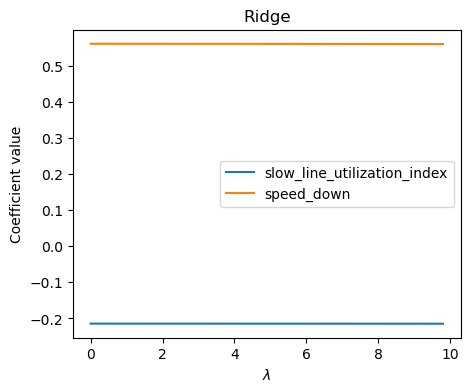

In [16]:
# the changes of coefficients
fig, ax = plt.subplots(figsize=(5,4))
ax.plot(coefs)
ax.set_xlabel('$\lambda$')

ax.set_xticks(range(0,51,10))
ax.set_xticklabels(range(0,11,2))
ax.set_ylabel('Coefficient value')
ax.legend(X.columns)
ax.set_title('Ridge');

In [17]:
warnings.filterwarnings("ignore", category=UserWarning)

In [18]:
coefs = []
for a in np.arange(0,10,0.2):
     # alpha is the complexity para, i.e., lambda
    reg_lasso = linear_model.Lasso(alpha=a).fit(X_train, y_train)
    coefs.append(reg_lasso.coef_)
coefs = pd.DataFrame(coefs)

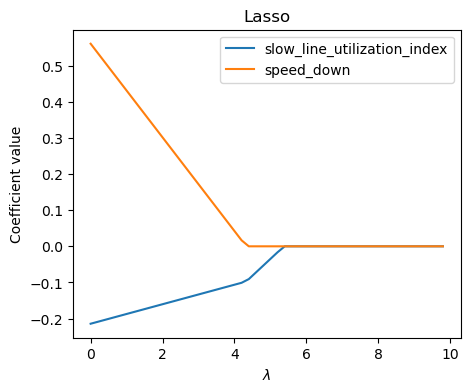

In [19]:
# the changes of coefficients
fig, ax = plt.subplots(figsize=(5,4))
ax.plot(coefs)
ax.set_xlabel('$\lambda$')

ax.set_xticks(range(0,51,10))
ax.set_xticklabels(range(0,11,2))
ax.set_ylabel('Coefficient value')
ax.legend(X.columns)
ax.set_title('Lasso');